## **Import Library**

In [1]:
import os
import random
import shutil
import hashlib
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_recall_curve, roc_curve, auc, precision_score, recall_score, roc_auc_score
from PIL import Image


# **Data Preprocessing and Data Split**

The provided dataset contains two files, 'gender' and 'gender_rev2'. The image data in both files are data segmented by the author. The authors split it into three files 'test', 'train', and 'valid'. Each file contains two categories, 'male' and 'female'. There were a total of 3891 files. To make the data more adaptable with the task in this study. First I contained an 'Image_Datasets' file, which created an 'original_dataset' file. 'original_dataset' file contains two empty files for 'male' and 'female'. Then I took the author's 3891 image files and put them into the male and female files. Also I used the author's 'image to predict' file to test the actual recognition ability of the model. After that start this experiment.
Datasets URL:https://www.kaggle.com/datasets/gpiosenka/gender-classification-from-an-image 

    Data Checking and Cleaning 

    Data augmentation

    Data Split

    Data Preprocessing

In [2]:
def preprocess_data():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    return train_datagen, val_test_datagen

def load_datasets(train_datagen, val_test_datagen, batch_size=64, target_size=(120, 100)):
    train_dir = "Image_Datasets/splited_dataset/train" 
    val_dir = "Image_Datasets/splited_dataset/validation"
    test_dir = "Image_Datasets/splited_dataset/test"

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb',
    )

    validation_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb',
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb'
    )

    return train_generator, validation_generator, test_generator

train_datagen, val_test_datagen = preprocess_data()
train_generator, validation_generator, test_generator = load_datasets(train_datagen, val_test_datagen)


Found 8068 images belonging to 2 classes.
Found 1008 images belonging to 2 classes.
Found 1010 images belonging to 2 classes.


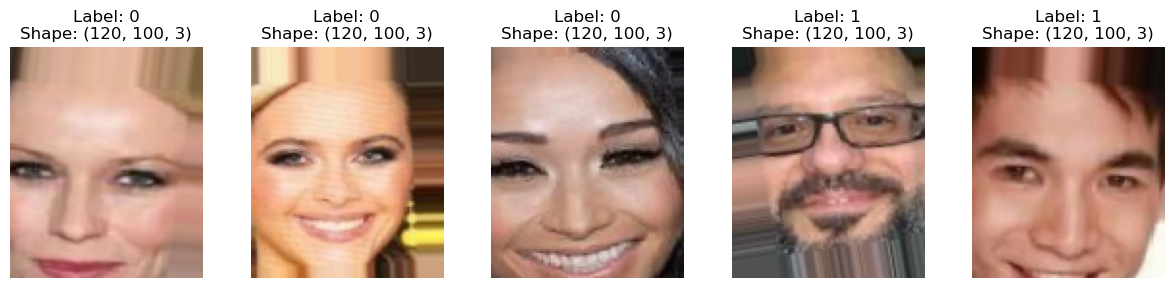

In [3]:
def display_sample_images_with_info_after_preprocessing(generator, num_images=5):
    images, labels = next(generator)

    selected_indices = np.random.choice(images.shape[0], num_images, replace=False)

    plt.figure(figsize=(15, 3))
    for i, index in enumerate(selected_indices):
        img = images[index]
        label = labels[index]
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f'Label: {np.argmax(label)}\nShape: {img.shape}')
        plt.axis('off')

    plt.show()

display_sample_images_with_info_after_preprocessing(train_generator)

# **Model Construction**

    Model 1

In [6]:
def depthwise_separable_resnet_block(input_tensor, filters, kernel_size=3, stride=1,conv_shortcut=False):
    
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.DepthwiseConv2D(kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    if conv_shortcut or stride != 1 or input_tensor.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same")(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x

def squeeze_excitation_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)
    se = layers.Dense(filters // ratio, activation='relu', kernel_regularizer=l2(0.001), use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_regularizer=l2(0.001), use_bias=False)(se)

    x = layers.multiply([input_tensor, se])
    return x


def inception_with_SE_block(input_tensor, filters, l2_rate):

    conv1x1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(input_tensor)

    conv3x3 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(input_tensor)

    conv5x5_1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(input_tensor)
    conv5x5_2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(conv5x5_1)
    conv5x5_3 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(conv5x5_2)

    pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    pool_conv = layers.Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(pool)

    outputs = layers.concatenate([conv1x1, conv3x3, conv5x5_3, pool_conv], axis=-1)
    output_with_se = squeeze_excitation_block(outputs)
    return output_with_se


    Model 2

    Spatial Attention and Effect

In [7]:
def spatial_attention_block(input_tensor):
    avg_pool = layers.GlobalAveragePooling2D()(input_tensor)
    max_pool = layers.GlobalMaxPooling2D()(input_tensor)
    
    avg_pool = layers.Reshape((1, 1, input_tensor.shape[-1]))(avg_pool)
    max_pool = layers.Reshape((1, 1, input_tensor.shape[-1]))(max_pool)
    
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)

    output_tensor = layers.Multiply()([input_tensor, attention])
    return output_tensor


    Ensemble model

In [8]:
def Franklin_ensemble_model_1(input_shape, num_classes, l2_rate):
    inputs = layers.Input(shape=input_shape)

    x = depthwise_separable_resnet_block(inputs, filters=64)
    x = depthwise_separable_resnet_block(x, filters=32)
    x = spatial_attention_block(x)

    x = layers.Conv2D(32, (5, 5), strides=2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = spatial_attention_block(x)

    x = inception_with_SE_block(x, 32, l2_rate)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = spatial_attention_block(x) 
      
    x = inception_with_SE_block(x, 32, l2_rate) 
    x = spatial_attention_block(x) 
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    combined_model_with_attention = models.Model(inputs=inputs, outputs=outputs)
    return combined_model_with_attention

input_2 InputLayer
conv2d_23 Conv2D
batch_normalization_8 BatchNormalization
re_lu_8 ReLU
conv2d_24 Conv2D
batch_normalization_9 BatchNormalization
re_lu_9 ReLU
depthwise_conv2d_2 DepthwiseConv2D
batch_normalization_10 BatchNormalization
conv2d_25 Conv2D
re_lu_10 ReLU
batch_normalization_11 BatchNormalization
add_2 Add
re_lu_11 ReLU
conv2d_26 Conv2D
batch_normalization_12 BatchNormalization
re_lu_12 ReLU
conv2d_27 Conv2D
batch_normalization_13 BatchNormalization
re_lu_13 ReLU
depthwise_conv2d_3 DepthwiseConv2D
batch_normalization_14 BatchNormalization
conv2d_28 Conv2D
re_lu_14 ReLU
batch_normalization_15 BatchNormalization
add_3 Add
re_lu_15 ReLU
global_average_pooling2d_7 GlobalAveragePooling2D
global_max_pooling2d_4 GlobalMaxPooling2D
reshape_10 Reshape
reshape_11 Reshape
concatenate_6 Concatenate
conv2d_29 Conv2D
multiply_6 Multiply
conv2d_30 Conv2D
max_pooling2d_4 MaxPooling2D
global_average_pooling2d_8 GlobalAveragePooling2D
global_max_pooling2d_5 GlobalMaxPooling2D
reshape_12 Res

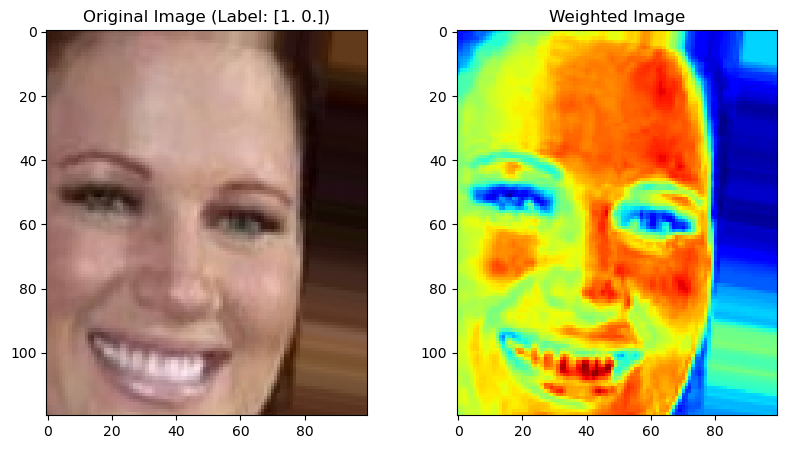

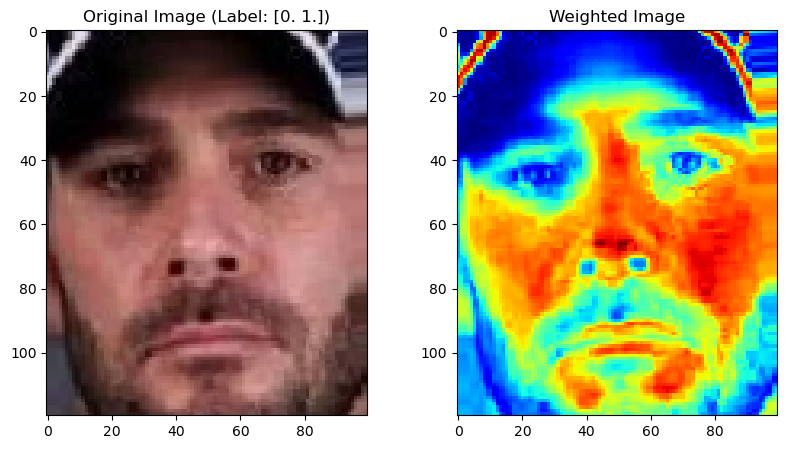

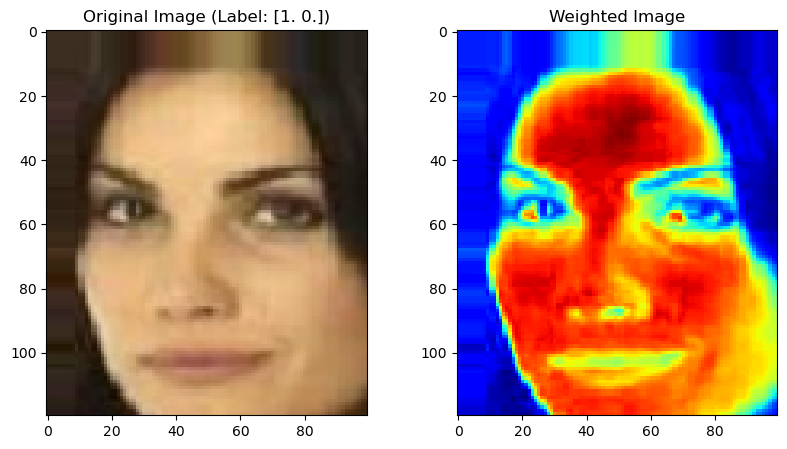

In [8]:
def attention_visualization_model(input_shape, num_classes, l2_rate):
    inputs = layers.Input(shape=input_shape)
    x = depthwise_separable_resnet_block(inputs, filters=64)
    x = depthwise_separable_resnet_block(x, filters=32)
    x = spatial_attention_block(x)

    x = layers.Conv2D(32, (5, 5), strides=2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = spatial_attention_block(x)

    x = inception_with_SE_block(x, 32, l2_rate)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = spatial_attention_block(x) 
      
    x = inception_with_SE_block(x, 32, l2_rate) 
    x = spatial_attention_block(x) 
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    attention_visualization_model = models.Model(inputs=inputs, outputs=outputs)
    return attention_visualization_model

def generate_grad_cam(model, img_array, target_layer, output_layer):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(target_layer).output, model.get_layer(output_layer).output]
    )

    with tf.GradientTape() as tape:
        conv_output, model_output = grad_model(img_array)
        loss = tf.reduce_max(model_output, axis=1)
    grads = tape.gradient(loss, conv_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

    return heatmap
input_shape = (120, 100, 3)
model = attention_visualization_model(input_shape, num_classes=2, l2_rate=0.0001)
for layer in model.layers:
    print(layer.name, layer.__class__.__name__)


def find_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No convolutional layers found in the model.")

last_conv_layer_name = find_last_conv_layer_name(model)
print(last_conv_layer_name)

output_layer_name = model.output.name.split("/")[0]

num_images = 3 

for i in range(num_images):
    batch = next(test_generator)

    img_array = batch[0]
    label = batch[1]

    heatmap1 = generate_grad_cam(model, img_array, last_conv_layer_name, output_layer_name)


    target_size = heatmap1.shape[0], heatmap1.shape[1]
    heatmap1_resized = tf.image.resize(heatmap1[..., np.newaxis], target_size)[..., 0]

    heatmap = heatmap1_resized 

    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (input_shape[0], input_shape[1]))[..., 0]
    heatmap_expanded = tf.stack([heatmap_resized, heatmap_resized, heatmap_resized], axis=-1)


    weighted_img = heatmap_expanded * img_array[0]
    weighted_img /= np.max(weighted_img) if np.max(weighted_img) != 0 else 1


    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img_array[0])
    plt.title(f'Original Image (Label: {label[0]})')

    plt.subplot(1, 3, 2)
    plt.imshow(weighted_img[..., 0],cmap='jet')
    plt.title('Weighted Image')

    plt.show()


# **Model Training**

    Visualization of Loss, Accuracu, AUC, ROC, Precision, PRC, F1-score, Recall, Sensitivity, Specificity, Confusion Matrix.

In [3]:
def plot_training_history(history):
    acc = history.history['custom_accuracy']
    val_acc = history.history['val_custom_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    recall = history.history['recall']
    val_recall = history.history['val_recall']

    epochs = range(len(acc))


    plt.figure(figsize=(12, 12))

    plt.subplot(3, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 2, 3)
    plt.plot(epochs, precision, label='Training Precision')
    plt.plot(epochs, val_precision, label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.plot(epochs, recall, label='Training Recall')
    plt.plot(epochs, val_recall, label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    
    # plt.suptitle("Model using custom_categorical_crossentropy", fontsize=20)
    plt.tight_layout()
    plt.show()

def load_and_predict_model(model_path, test_generator, custom_objects):
    loaded_model = load_model(model_path, custom_objects=custom_objects)
    all_images = []
    all_true_labels = []

    for _ in range(test_generator.samples // test_generator.batch_size):
        images, true_labels = next(test_generator)
        all_images.extend(images)
        all_true_labels.extend(true_labels)

    all_images = np.array(all_images)
    all_true_labels = np.argmax(np.array(all_true_labels), axis=1)

    predictions = loaded_model.predict(all_images)
    predicted_labels = np.argmax(predictions, axis=1)

    return all_true_labels, predicted_labels, predictions

def calculate_f1_scores(true_labels, predicted_probabilities):
    thresholds = np.linspace(0, 1, 100)
    f1_scores = []

    for thresh in thresholds:
        predicted_labels_thresh = (predicted_probabilities[:, 1] >= thresh).astype(int)

        precision = precision_score(true_labels, predicted_labels_thresh, zero_division=0)
        recall = recall_score(true_labels, predicted_labels_thresh)

        if precision + recall == 0:
            f1_scores.append(0)
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
            f1_scores.append(f1)

    return thresholds, f1_scores

def calculate_sensitivity_specificity(true_labels, predicted_probabilities):
    thresholds = np.linspace(0, 1, 100)
    sensitivity_scores = []
    specificity_scores = []

    for thresh in thresholds:
        predicted_labels_thresh = (predicted_probabilities[:, 1] >= thresh).astype(int)

        tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels_thresh).ravel()

        sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

        sensitivity_scores.append(sensitivity)
        specificity_scores.append(specificity)

    return thresholds, sensitivity_scores, specificity_scores


def plot_confusion_matrix(true_labels, predicted_labels):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


def plot_roc_auc_curve(true_labels, predicted_probabilities):
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities[:, 1]) 
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (Area Under the Curve = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(true_labels, predicted_probabilities):
    precision, recall, _ = precision_recall_curve(true_labels, predicted_probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

def plot_f1_scores(thresholds, f1_scores):
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, f1_scores, marker='.')
    plt.title('F1-Score as a function of the decision threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.show()

def plot_sensitivity(thresholds, sensitivity_scores):
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, sensitivity_scores, marker='.')
    plt.title('Sensitivity as a function of the decision threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Sensitivity')
    plt.show()

def plot_specificity(thresholds, specificity_scores):
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, specificity_scores, marker='.')
    plt.title('Specificity as a function of the decision threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Specificity')
    plt.show()

def print_classification_metrics(true_labels, predicted_labels, predicted_probabilities):
    cm = confusion_matrix(true_labels, predicted_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    auc = roc_auc_score(true_labels, predicted_probabilities[:, 1]) if predicted_probabilities is not None else "N/A"

    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels))
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"AUC: {auc}")
    print("Confusion Matrix:")
    print(cm)
    


    Customize loss and Accuracy

In [9]:
def custom_categorical_crossentropy(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
    loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
    return loss

def custom_accuracy(y_true, y_pred):
    predicted_classes = tf.argmax(y_pred, axis=1)
    true_classes = tf.argmax(y_true, axis=1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_classes, true_classes), tf.float32))
    return accuracy

    Training model using custom custom_categorical_crossentropy and custom_accuracy

        Training model 1

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='min')
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

Franklin_ensemble_model_1 = Franklin_ensemble_model_1((120, 100, 3), num_classes=2, l2_rate=0.001)
Franklin_ensemble_model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss=custom_categorical_crossentropy,
                       metrics=[custom_accuracy, Precision(name='precision'), Recall(name='recall')]
)
Franklin_ensemble_model_1.summary()
print(Franklin_ensemble_model_1.optimizer) 
print(Franklin_ensemble_model_1.loss)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 120, 100, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 120, 100, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [10]:
history1 = Franklin_ensemble_model_1.fit(train_generator, epochs=50, validation_data=validation_generator,callbacks=[early_stopping, lr_reduction])

Epoch 1/50
127/127 [==============================] - 16s 113ms/step - loss: 0.8183 - custom_accuracy: 0.6598 - precision: 0.6573 - recall: 0.6573 - val_loss: 0.7831 - val_custom_accuracy: 0.5026 - val_precision: 0.5020 - val_recall: 0.5020 - lr: 0.0010
Epoch 2/50
127/127 [==============================] - 12s 97ms/step - loss: 0.5006 - custom_accuracy: 0.8017 - precision: 0.8021 - recall: 0.8021 - val_loss: 0.8932 - val_custom_accuracy: 0.4990 - val_precision: 0.5000 - val_recall: 0.5000 - lr: 0.0010
Epoch 3/50
127/127 [==============================] - 12s 97ms/step - loss: 0.4050 - custom_accuracy: 0.8346 - precision: 0.8334 - recall: 0.8334 - val_loss: 0.9931 - val_custom_accuracy: 0.5003 - val_precision: 0.5000 - val_recall: 0.5000 - lr: 0.0010
Epoch 4/50
127/127 [==============================] - 12s 96ms/step - loss: 0.3574 - custom_accuracy: 0.8540 - precision: 0.8547 - recall: 0.8547 - val_loss: 1.0237 - val_custom_accuracy: 0.5195 - val_precision: 0.5208 - val_recall: 0.5208 

In [4]:
model_path1 = 'model_test_save/4attentiontest.h5'
Franklin_ensemble_model_1.save(model_path1)


        Train model 2

# **Model Testing and Evaluation**

    Evaluate and Visualize Loss, Accuracy, AUC, ROC, Precision, PRC, F1-score, Recall, Sensitivity, Specificity, Confusion Matrix.

        Model 1 testing and evaluation

30/30 [==============================] - 1s 9ms/step


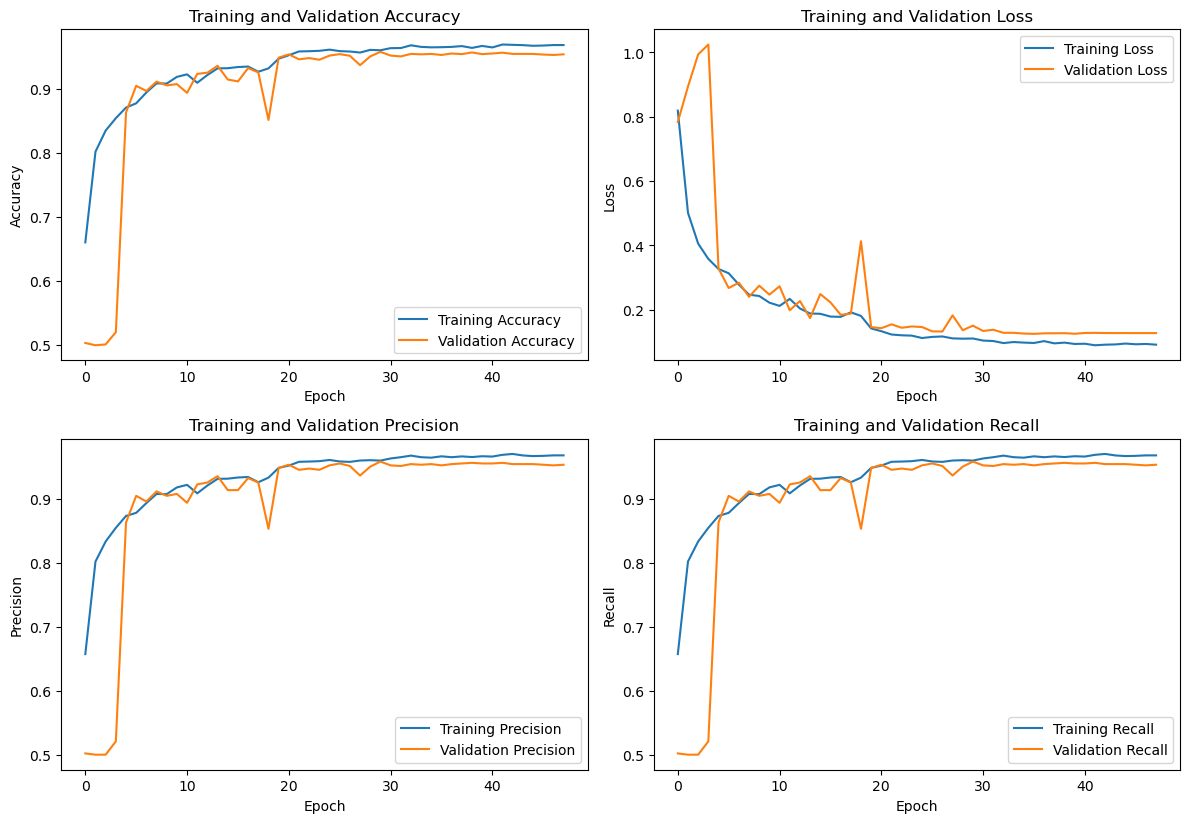

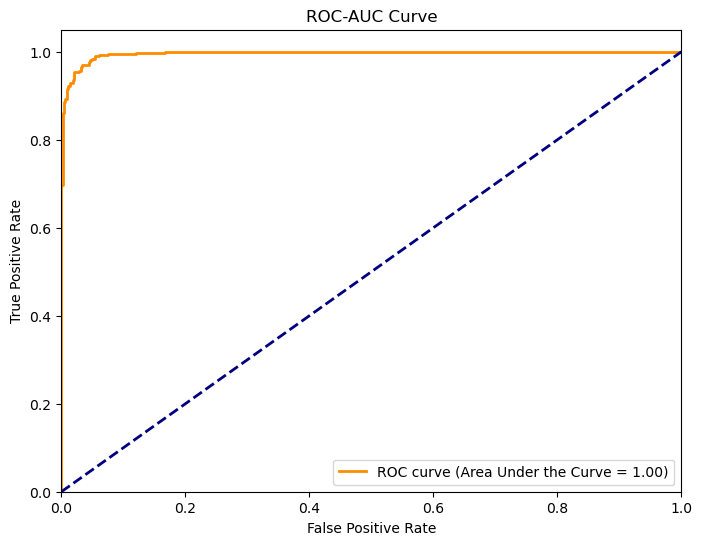

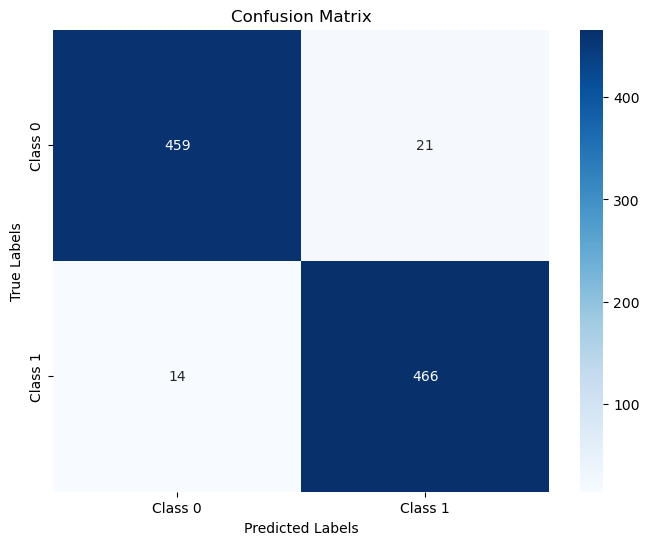

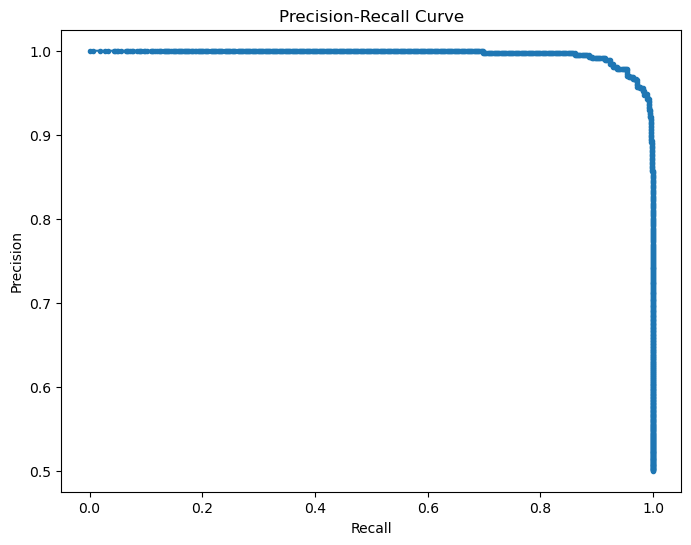

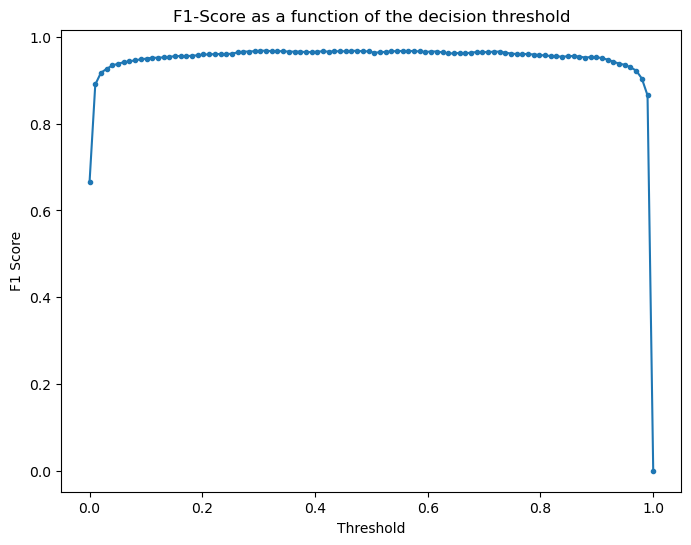

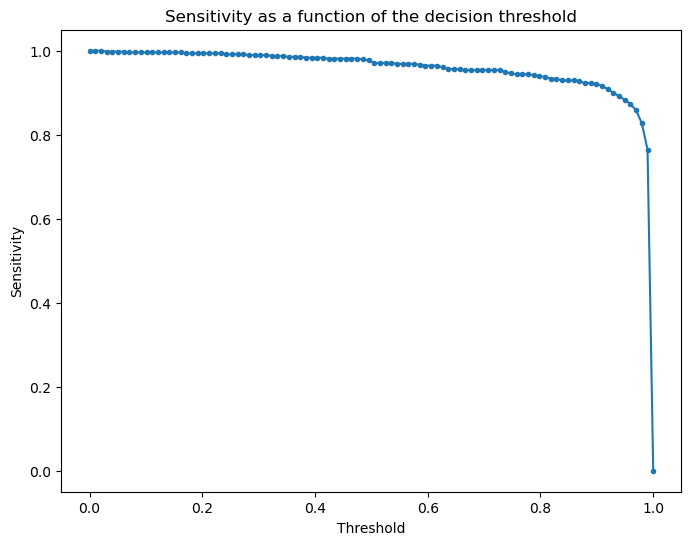

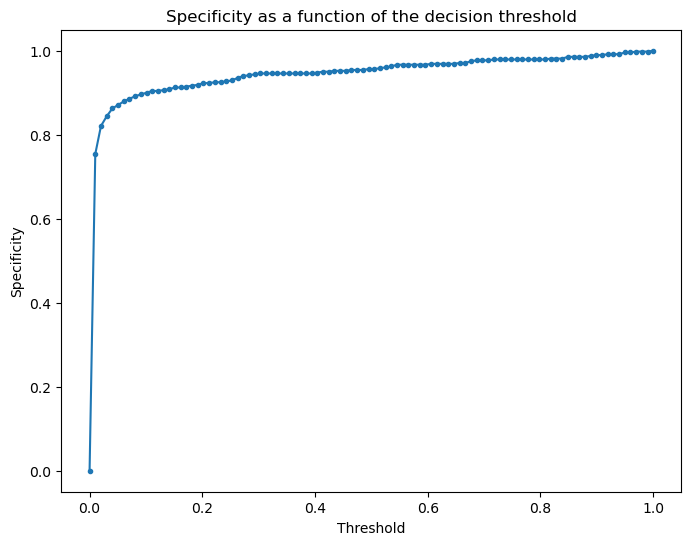

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       480
           1       0.96      0.97      0.96       480

    accuracy                           0.96       960
   macro avg       0.96      0.96      0.96       960
weighted avg       0.96      0.96      0.96       960

Sensitivity: 0.97
Specificity: 0.96
Precision: 0.96
Recall: 0.97
F1 Score: 0.96
AUC: 0.9961414930555555
Confusion Matrix:
[[459  21]
 [ 14 466]]
7/7 [==============================] - 0s 26ms/step - loss: 0.0679 - custom_accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732


In [12]:
model_path = model_path1
custom_objects={'custom_categorical_crossentropy': custom_categorical_crossentropy,'custom_accuracy': custom_accuracy}
true_labels, predicted_labels, predicted_probabilities = load_and_predict_model(model_path, test_generator, custom_objects)


plot_training_history(history1)

plot_roc_auc_curve(true_labels, predicted_probabilities)
plot_confusion_matrix(true_labels, predicted_labels)
plot_precision_recall_curve(true_labels, predicted_probabilities)

thresholds, f1_scores = calculate_f1_scores(true_labels, predicted_probabilities)
plot_f1_scores(thresholds, f1_scores)

thresholds, sensitivity_scores, specificity_scores = calculate_sensitivity_specificity(true_labels, predicted_probabilities)
plot_sensitivity(thresholds, sensitivity_scores)
plot_specificity(thresholds, specificity_scores)

print_classification_metrics(true_labels, predicted_labels, predicted_probabilities)

evaluation_result = Franklin_ensemble_model_1.evaluate(test_generator, steps=7)


1/1 [==============================] - 0s 226ms/step


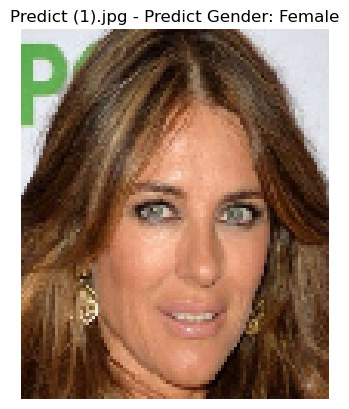

1/1 [==============================] - 0s 11ms/step


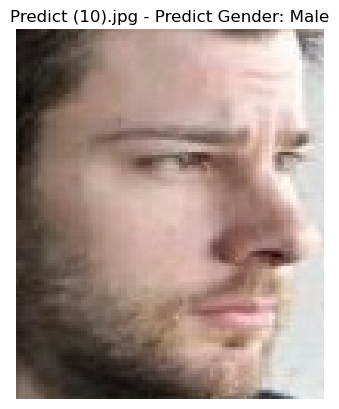

1/1 [==============================] - 0s 12ms/step


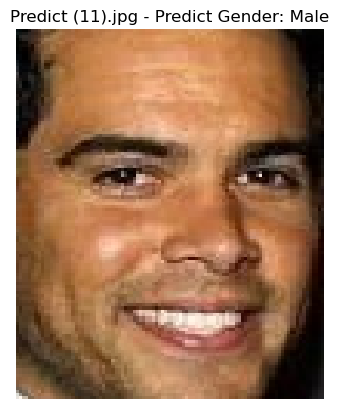

1/1 [==============================] - 0s 11ms/step


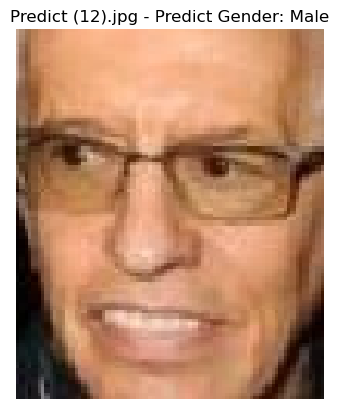

1/1 [==============================] - 0s 12ms/step


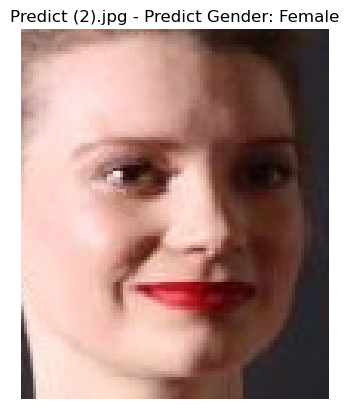

1/1 [==============================] - 0s 11ms/step


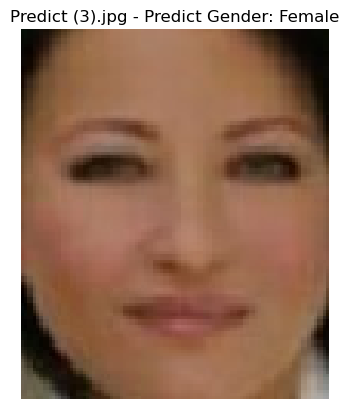

1/1 [==============================] - 0s 12ms/step


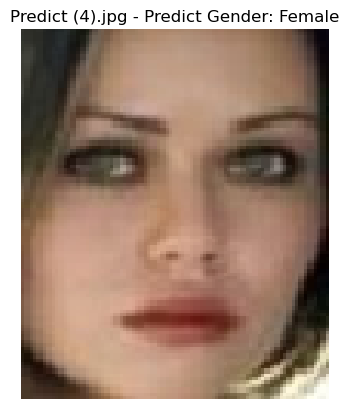

1/1 [==============================] - 0s 11ms/step


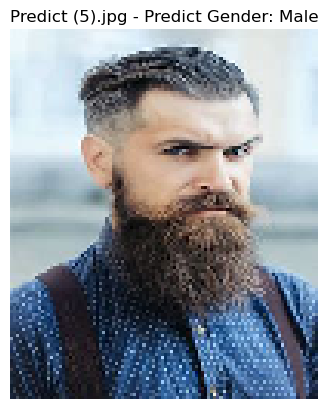

1/1 [==============================] - 0s 12ms/step


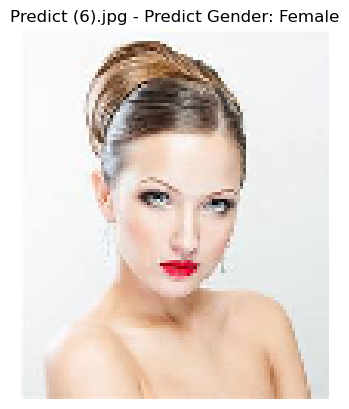

1/1 [==============================] - 0s 12ms/step


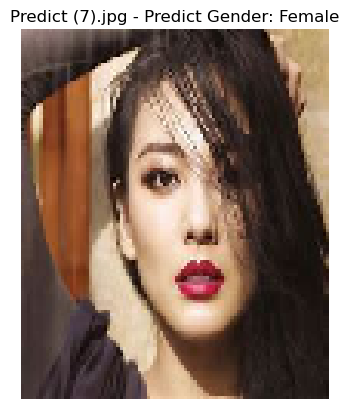

1/1 [==============================] - 0s 12ms/step


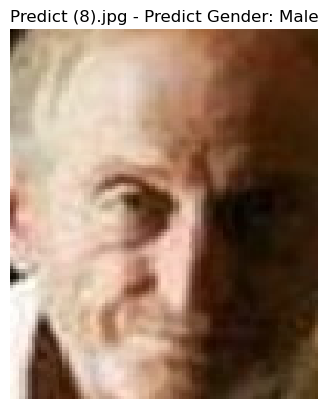

1/1 [==============================] - 0s 13ms/step


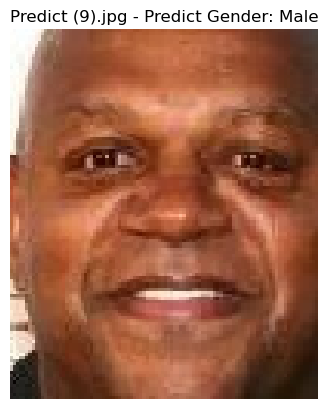

In [13]:
model = load_model(model_path1, custom_objects={'custom_categorical_crossentropy': custom_categorical_crossentropy, 'custom_accuracy': custom_accuracy})
folder_path = 'Image_Datasets/images to predict'  

for img_file in os.listdir(folder_path):
    if img_file.endswith(".jpg") or img_file.endswith(".png"):  
        img_path = os.path.join(folder_path, img_file)
        img = image.load_img(img_path, target_size=(120, 100))  
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  
        img_array /= 255.0  

        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)
        prediction_text = "Female" if predicted_class[0] == 0 else "Male"

        plt.imshow(img)
        plt.title(f"{img_file} - Predict Gender: {prediction_text}")
        plt.axis('off')  
        plt.show()

        Model 2 testing and evaluation

    Compare model evaluation using in-build loss and accuracy

        Training model 1 using in-build loss and accuracy

        Training model 2 using in-build loss and accuracy

    Compare model with not using attention mechanism

        Model 1 not using attention

        Model 2 not using attention

    Hyparameter TEST (file name: compare_model_with_pre_train_model)

    Compare model_1 and model_2 with Pre-train models (ResNet101, InceptionV3, and MobileNetV2)
    (file name: hyperparameter_tuning_test)

# **Bonus Point**

    Training model using custom weighted_cumulative_crossentropy loss function.

        Model 1 using using custom weighted_cumulative_crossentropy loss function.

        Model 2 using using custom weighted_cumulative_crossentropy loss function.